Convert ipynb to pdf : __jupyter nbconvert –to pdf file_name.ipynb__

# <font color='blue'> Data Science Exercise - David Tang </font>
### Scenario
You work in a team that provides online advertising for a range of clients. Recently, the team has begun to collect rich data on each display advert shown to a customer, and whether that advert was clicked on by the customer. You have been asked to lead the work on this new type of analysis, by creating tools to simplify the
analysis of this kind of data and by developing a model to predict the probability that a given
impression will lead to a click. In production, we would hope to use this model to improve the
performance of our campaigns which serve millions of impressions per day.  
### Data sets
You have available to you the following data samples to develop your work. When working with our
data, we typically use the Python packages json, datetime and pandas; feel free to use those or
any other packages you wish.
### campaign_impressions.json
Log of ad impressions seen by users for the campaigns in question. The data in this file has the following structure:  
♦ uuid : unique identifier for the user who saw the ad impression  
♦ ts : timestamp at which the ad impression was shown to the user  
♦ <font color='red'> conv : whether the impression led to an in-store conversion </font>  
♦ resp.oi : unique identifier for the client for whom the advertising campaign was run  
♦ resp.cr : unique identifier for the content of the advert shown to the user  
♦ resp.c : unique identifier for the advertising campaign of the impression shown to the user  
♦ dev.os : unique identifier for the operating system of the user’s device  
♦ dev.sid : unique identifier for the source of the data  
♦ dev.app : unique identifier of the app on which the user saw the ad impression    

### user_segments.csv
The user segments database denoting to which segments the user belongs:  
♦ USER_ID : unique identifier for a user (equivalent to the uuid field in the log of ad impressions)  
  is named "Unnamed: 0" in the CSV file   
♦ ANIMAL : whether the user has been identified as having a pet  
♦ CAR_OWNER : whether the user has been identified as owning a car  
♦ GARDEN : whether the user has been identified as owning a garden  
♦ OFFICE_WORKER: whether the user has been identified as working in an office  
♦ PARENT : whether the user has been identified as a parent    

Your job is to predict how many people will convert after seeing an impression for an advertising
campaign.
### Tasks
There are three tasks for you to complete in this scenario. Please consider each to have equal importance.

# <font color='blue'> 0. Packages import </font>

In [211]:
# Data analysis and manipulation
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json
from datetime import datetime

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Classifiers from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier 

# Classifiers from other packages : pip install lightgbm | pip install xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise 
# tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. 
# However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.utils import compute_sample_weight
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# Scoring metrics
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, f1_score
from sklearn.metrics import auc, confusion_matrix, make_scorer

# Saving models 
from sklearn.externals import joblib

# System warnings and version
import sys
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
print('Python version:', sys.version)

Python version: 3.6.8 |Anaconda custom (64-bit)| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


# <font color='blue'> 1. Software development in Python: Write a class to represent the data contained in each ad impression log, and to simplify analysis of these logs. 

<font color='blue'> The aim of this task is to identify your comfort with object-oriented programming in Python and your ability to write clean code. Please make use of any resources available to you. Consider the below as a starting point for a class you could write.</font>

## 1.1 Reading and preparing the json and csv file

In [212]:
# Reading the Json file to a list of dictionaries
logs = []
for line in open('campaign_impressions.json', 'r'):
    logs.append(json.loads(line))

# Due to the nested columns, I normalize the data
df_logs = pd.DataFrame.from_dict(json_normalize(logs), orient='columns')

# Convert uuid column from object to int in order to the merge with the user dataframe
df_logs['uuid'] = df_logs['uuid'].astype(str).astype(int)
df_logs.sort_values('uuid').head()
logs = df_logs.to_dict('records')
logs

[{'conv': 0,
  'dev.app': 7,
  'dev.os': 4,
  'dev.sid': 16,
  'resp.c': 2,
  'resp.cr': 4.0,
  'resp.oi': 8,
  'ts': 1512090065,
  'uuid': 316},
 {'conv': 0,
  'dev.app': 22,
  'dev.os': 4,
  'dev.sid': 26,
  'resp.c': 3,
  'resp.cr': 3.0,
  'resp.oi': 8,
  'ts': 1512101925,
  'uuid': 430},
 {'conv': 1,
  'dev.app': 7,
  'dev.os': 5,
  'dev.sid': 26,
  'resp.c': 3,
  'resp.cr': 7.0,
  'resp.oi': 8,
  'ts': 1512164923,
  'uuid': 78},
 {'conv': 0,
  'dev.app': 7,
  'dev.os': 5,
  'dev.sid': 26,
  'resp.c': 3,
  'resp.cr': 6.0,
  'resp.oi': 8,
  'ts': 1512100131,
  'uuid': 242},
 {'conv': 1,
  'dev.app': 7,
  'dev.os': 5,
  'dev.sid': 26,
  'resp.c': 3,
  'resp.cr': 10.0,
  'resp.oi': 8,
  'ts': 1512137131,
  'uuid': 123},
 {'conv': 0,
  'dev.app': 7,
  'dev.os': 5,
  'dev.sid': 26,
  'resp.c': 1,
  'resp.cr': 10.0,
  'resp.oi': 8,
  'ts': 1512160208,
  'uuid': 148},
 {'conv': 1,
  'dev.app': 22,
  'dev.os': 4,
  'dev.sid': 26,
  'resp.c': 2,
  'resp.cr': 8.0,
  'resp.oi': 8,
  'ts': 151

In [213]:
# Reading the CSV file : user_segments.csv
df_segments = pd.read_csv('user_segments.csv')
df_segments = df_segments.rename(index=str, columns={"Unnamed: 0": "uuid",})
df_segments.sort_values('uuid').head()
segments = df_segments.to_dict('records')
segments

# Inner join the two dataframes to build the dictionnary we will use for our class
df = pd.merge(df_logs, df_segments, on='uuid')
df.sort_values('uuid').head()
logs = df.to_dict('records')
print('Number of logs comprised in a list of dictionnaries:', len(logs))
logs

Number of logs comprised in a list of dictionnaries: 10000


[{'conv': 0,
  'dev.app': 7,
  'dev.os': 4,
  'dev.sid': 16,
  'resp.c': 2,
  'resp.cr': 4.0,
  'resp.oi': 8,
  'ts': 1512090065,
  'uuid': 316,
  'ANIMAL': True,
  'CAR_OWNER': False,
  'GARDEN': False,
  'OFFICE_WORKER': True,
  'PARENT': True},
 {'conv': 0,
  'dev.app': 9,
  'dev.os': 4,
  'dev.sid': 26,
  'resp.c': 3,
  'resp.cr': 10.0,
  'resp.oi': 8,
  'ts': 1512091531,
  'uuid': 316,
  'ANIMAL': True,
  'CAR_OWNER': False,
  'GARDEN': False,
  'OFFICE_WORKER': True,
  'PARENT': True},
 {'conv': 1,
  'dev.app': 7,
  'dev.os': 5,
  'dev.sid': 16,
  'resp.c': 2,
  'resp.cr': 9.0,
  'resp.oi': 8,
  'ts': 1512097385,
  'uuid': 316,
  'ANIMAL': True,
  'CAR_OWNER': False,
  'GARDEN': False,
  'OFFICE_WORKER': True,
  'PARENT': True},
 {'conv': 1,
  'dev.app': 7,
  'dev.os': 5,
  'dev.sid': 16,
  'resp.c': 1,
  'resp.cr': 9.0,
  'resp.oi': 8,
  'ts': 1512127543,
  'uuid': 316,
  'ANIMAL': True,
  'CAR_OWNER': False,
  'GARDEN': False,
  'OFFICE_WORKER': True,
  'PARENT': True},
 {'conv

In [214]:
# Printing the first row (=log) of our impression log file 
logs[0]

{'conv': 0,
 'dev.app': 7,
 'dev.os': 4,
 'dev.sid': 16,
 'resp.c': 2,
 'resp.cr': 4.0,
 'resp.oi': 8,
 'ts': 1512090065,
 'uuid': 316,
 'ANIMAL': True,
 'CAR_OWNER': False,
 'GARDEN': False,
 'OFFICE_WORKER': True,
 'PARENT': True}

## 1.2 Defining the Impression class

In [215]:
class Impression(object):
    
    def __init__(self, log):
        ''' log : dict
            a single row of the impression log file '''
        self._log = log 
        self.uuid = int(log.get('uuid'))
        self.timestamp = log.get('ts')
        self.oi = log.get('resp.oi')
        self.cr = log.get('resp.cr')
        self.c = log.get('resp.c')
        self.os = log.get('dev.os')
        self.sid = log.get('dev.sid')
        self.app = log.get('dev.app')
        self.ANIMAL = log.get('ANIMAL')
        self.CAR_OWNER = log.get('CAR_OWNER')
        self.GARDEN = log.get('GARDEN')
        self.OFFICE_WORKER = log.get('OFFICE_WORKER')
        self.PARENT = log.get('PARENT')
        
    def didConvert(self):
        ''' Returns True if the conv associated with the log is 1'''
        return bool(self._log['conv'])
    
    def userHasSegment(self, segment_name):
        ''' Returns True if the UUID associated with the hit is marked as being in the given segment '''
        return bool(self._log[segment_name])

In [216]:
# Checking if our class works as expected (eg: 666th log)

# Building a list containing every impression object
logFile = []
for log in logs:
    logFile.append(Impression(log))  

# Checking all of the class' methods
print(logFile[666].uuid,
      logFile[666].timestamp,
      logFile[666].oi,
      logFile[666].cr,
      logFile[666].c,
      logFile[666].os,
      logFile[666].sid,
      logFile[666].app)

print(logFile[666].userHasSegment('ANIMAL'),
      logFile[666].userHasSegment('CAR_OWNER'),
      logFile[666].userHasSegment('GARDEN'),
      logFile[666].userHasSegment('OFFICE_WORKER'),
      logFile[666].userHasSegment('PARENT'))

print(logFile[666].didConvert())

print('\n', logFile[666]._log)

91 1512135953 8 2.0 1 4 26 7
False True False True False
True

 {'conv': 1, 'dev.app': 7, 'dev.os': 4, 'dev.sid': 26, 'resp.c': 1, 'resp.cr': 2.0, 'resp.oi': 8, 'ts': 1512135953, 'uuid': 91, 'ANIMAL': False, 'CAR_OWNER': True, 'GARDEN': False, 'OFFICE_WORKER': True, 'PARENT': False}


# <font color='blue'> 2. Machine learning: Develop a machine learning model to predict the probability that an impression will lead to an in-store conversion. 
<font color='blue'> The aim of this task is to identify your understanding of machine learning, and how it can be used to solve business problems. Typically, we use our Python classes to simplify feature generation, so feel free to make liberal use of the class you wrote for the first task. Please report the performance of each model you develop. Doing so will help us to better understand how you approached the problem; we won’t judge the actual score of your models. </font>

## 2.1 Generating features and building dataframe on which I will be conducting data analysis

In [217]:
# Creating a list for each feature generated, then assigning each list to a column of a new dataframe

uuid = []
timestamp = []
oi = []
cr = []
c = []
os = []
sid = []
app = []
ANIMAL = []
CAR_OWNER = []
GARDEN = []
OFFICE_WORKER = [] 
PARENT = []
didConvert = []

[uuid.append(logFile[log].uuid) for log in range(len(logFile))]
[timestamp.append(logFile[log].timestamp) for log in range(len(logFile))]
[oi.append(logFile[log].oi) for log in range(len(logFile))]
[cr.append(logFile[log].cr) for log in range(len(logFile))]
[c.append(logFile[log].c) for log in range(len(logFile))]
[os.append(logFile[log].os) for log in range(len(logFile))]
[sid.append(logFile[log].sid) for log in range(len(logFile))]
[app.append(logFile[log].app) for log in range(len(logFile))]

[ANIMAL.append(logFile[log].userHasSegment('ANIMAL')) for log in range(len(logFile))]
[CAR_OWNER.append(logFile[log].userHasSegment('CAR_OWNER')) for log in range(len(logFile))]
[GARDEN.append(logFile[log].userHasSegment('GARDEN')) for log in range(len(logFile))]
[OFFICE_WORKER.append(logFile[log].userHasSegment('OFFICE_WORKER')) for log in range(len(logFile))]
[PARENT.append(logFile[log].userHasSegment('PARENT')) for log in range(len(logFile))]

[didConvert.append(logFile[log].didConvert()) for log in range(len(logFile))]

DF = pd.DataFrame()
DF = DF.assign(uuid = uuid,
               timestamp=timestamp,
               oi = oi, 
               cr = cr,
               c = c,
               os = os,
               sid = sid,
               app = app,
               ANIMAL = ANIMAL,
               CAR_OWNER = CAR_OWNER,
               GARDEN = GARDEN,
               OFFICE_WORKER = OFFICE_WORKER,
               PARENT = PARENT, 
               didConvert = didConvert)

DF.head(100)

,uuid,timestamp,oi,cr,c,os,sid,app,ANIMAL,CAR_OWNER,GARDEN,OFFICE_WORKER,PARENT,didConvert
0,316,1512090065,8,4.0,2,4,16,7,True,False,False,True,True,False
1,316,1512091531,8,10.0,3,4,26,9,True,False,False,True,True,False
2,316,1512097385,8,9.0,2,5,16,7,True,False,False,True,True,True
3,316,1512127543,8,9.0,1,5,16,7,True,False,False,True,True,True
4,316,1512094618,8,9.0,1,4,26,22,True,False,False,True,True,False
5,316,1512149862,8,3.0,3,4,26,22,True,False,False,True,True,False
6,316,1512146001,8,5.0,3,4,16,9,True,False,False,True,True,False
7,316,1512104016,8,4.0,2,5,16,9,True,False,False,True,True,True
8,316,1512139936,8,9.0,2,4,26,7,True,False,False,True,True,True
9,316,1512126785,8,2.0,3,4,26,9,True,False,False,True,True,False


## 2.2 Data Analysis and Preprocessing

In [218]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
uuid             10000 non-null int64
timestamp        10000 non-null int64
oi               10000 non-null int64
cr               9471 non-null float64
c                10000 non-null int64
os               10000 non-null int64
sid              10000 non-null int64
app              10000 non-null int64
ANIMAL           10000 non-null bool
CAR_OWNER        10000 non-null bool
GARDEN           10000 non-null bool
OFFICE_WORKER    10000 non-null bool
PARENT           10000 non-null bool
didConvert       10000 non-null bool
dtypes: bool(6), float64(1), int64(7)
memory usage: 683.7 KB


In [219]:
# Desc Statistics 
DF.describe()

,uuid,timestamp,oi,cr,c,os,sid,app
count,10000.000000,1.000000e+04,10000.0,9471.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,249.013200,1.512129e+09,8.0,5.523598,1.992300,4.494900,20.968000,12.675000
std,143.772926,2.492343e+04,0.0,2.870350,0.813945,0.499999,5.000148,6.663018
min,0.000000,1.512086e+09,8.0,1.000000,1.000000,4.000000,16.000000,7.000000
25%,126.000000,1.512108e+09,8.0,3.000000,1.000000,4.000000,16.000000,7.000000
50%,249.000000,1.512129e+09,8.0,6.000000,2.000000,4.000000,16.000000,9.000000
75%,372.000000,1.512151e+09,8.0,8.000000,3.000000,5.000000,26.000000,22.000000
max,499.000000,1.512173e+09,8.0,10.000000,3.000000,5.000000,26.000000,22.000000


### Missing values
There are a few missing values in our dataset regarding the CR feature (unique id for the content of the advert shown to the user). In this particular case, I could replace missing values with the mode, but due to small % of missing values, I decide to delete them assuming this will only cause a small loss in precision in my model. Usually, regarding missing values for quantitative features, we can replace them with the median, the arithmetic mean, with values using a knn, etc.

In [220]:
# Missing Values
print('# training examples before deleting missing values :', len(DF))
print(DF.isnull().sum())

# training examples before deleting missing values : 10000
uuid               0
timestamp          0
oi                 0
cr               529
c                  0
os                 0
sid                0
app                0
ANIMAL             0
CAR_OWNER          0
GARDEN             0
OFFICE_WORKER      0
PARENT             0
didConvert         0
dtype: int64


In [221]:
DF.dropna(inplace=True)
print('# training examples after deleting missing values :', len(DF), 
      '\nDeleting {}% of the dataset observations'.format(529*100/10000))

# training examples after deleting missing values : 9471 
Deleting 5.29% of the dataset observations


### Data distributions

The dataset is unbalanced, positive conversion representing 30.75% observations. Therefore we will be using the F1 score metric as well as the AUC of the precision-recall curve for the model we will build later. When assessing the distribution of the categorical features, we see that that some features are unbalanced with a lower frequecy for the True class regarding each segment user: True (ANIMAL), True (CAR_OWNER), True (GARDEN), True (OFFICE_WORKER), True (Parent). On the other hand, when looking at the conversion ratio per category, we see that the OS "5" is over-represented with more than 40% against 20% for the OS "4".

False    6558
True     2913
Name: didConvert, dtype: int64


Text(0.5, 1.0, 'distribution des données de conversion')

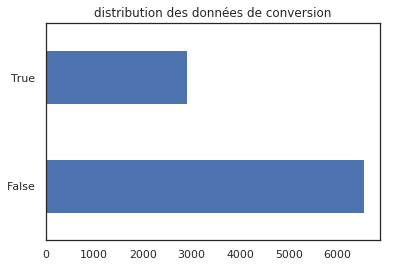

In [222]:
print(DF.didConvert.value_counts())
DF.didConvert.value_counts().plot(kind='barh')
plt.title('distribution des données de conversion')

Distribution of categorical features:


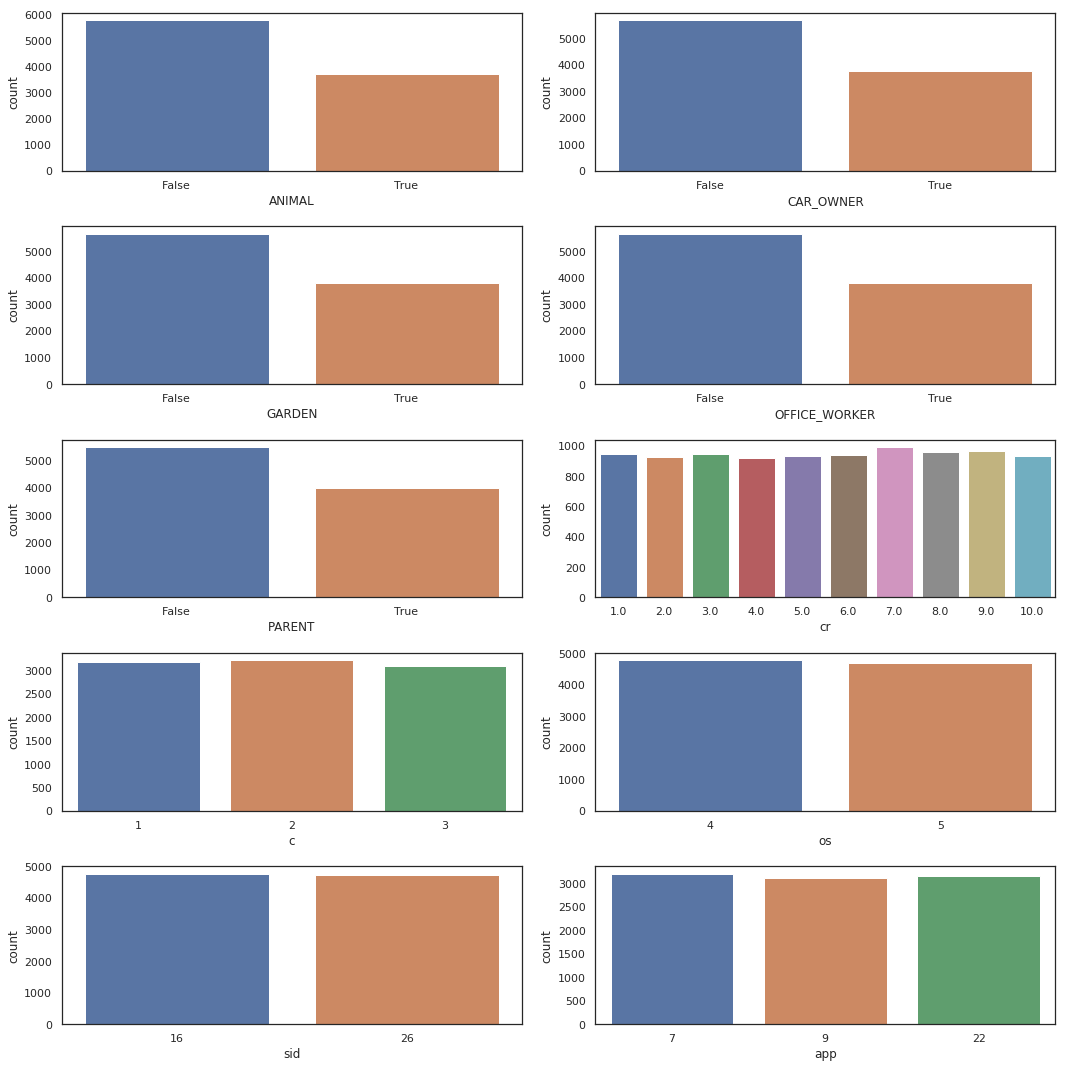

In [223]:
# Distribution of categorical features

sns.set(font_scale=1, style='white')
_, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,15))
print('Distribution of categorical features:')
sns.countplot(data=DF, x='ANIMAL', ax=ax[0,0])
sns.countplot(data=DF, x='CAR_OWNER', ax=ax[0,1])
sns.countplot(data=DF, x='GARDEN', ax=ax[1,0])
sns.countplot(data=DF, x='OFFICE_WORKER', ax=ax[1,1])
sns.countplot(data=DF, x='PARENT', ax=ax[2,0])
sns.countplot(data=DF, x='cr', ax=ax[2,1])
sns.countplot(data=DF, x='c', ax=ax[3,0])
sns.countplot(data=DF, x='os', ax=ax[3,1])
sns.countplot(data=DF, x='sid', ax=ax[4,0])
sns.countplot(data=DF, x='app', ax=ax[4,1])
plt.tight_layout()

Conversion ratio per category:


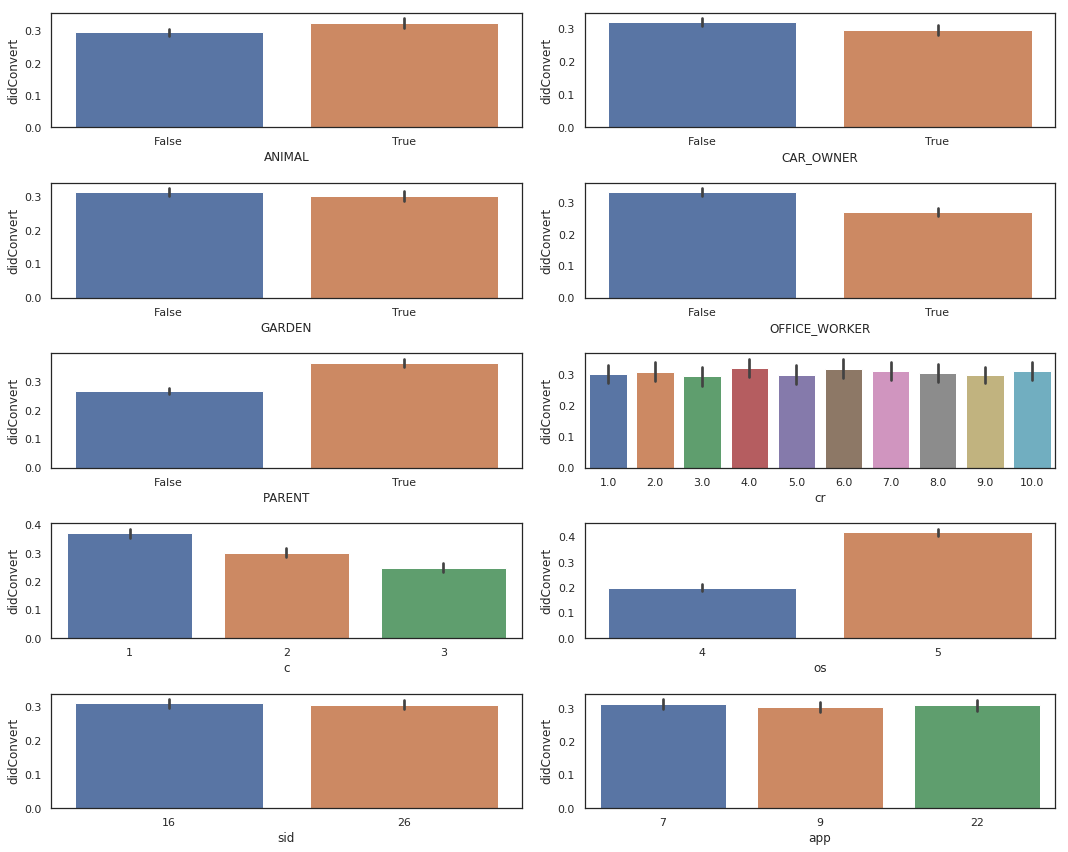

In [224]:
# Conversion ratio per category

print('Conversion ratio per category:')
sns.set(font_scale=1, style='white')
_, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,12), sharey=False)
sns.barplot(x="ANIMAL",y="didConvert",data=DF, ax=ax[0,0])
sns.barplot(x="CAR_OWNER",y="didConvert",data=DF, ax=ax[0,1])
sns.barplot(x="GARDEN",y="didConvert",data=DF, ax=ax[1,0])
sns.barplot(x="OFFICE_WORKER",y="didConvert",data=DF, ax=ax[1,1])
sns.barplot(x="PARENT",y="didConvert",data=DF, ax=ax[2,0])
sns.barplot(x="cr",y="didConvert",data=DF, ax=ax[2,1])
sns.barplot(x="c",y="didConvert",data=DF, ax=ax[3,0])
sns.barplot(x="os",y="didConvert",data=DF, ax=ax[3,1])
sns.barplot(x="sid",y="didConvert",data=DF, ax=ax[4,0])
sns.barplot(x="app",y="didConvert",data=DF, ax=ax[4,1])
plt.tight_layout()

In [225]:
# Most converted UUID
DF[["uuid","didConvert"]].groupby('uuid').mean().sort_values(by='didConvert', ascending=False)

,didConvert
uuid,
490,0.800000
108,0.800000
126,0.680000
182,0.666667
467,0.647059
435,0.642857
106,0.625000
24,0.615385
234,0.611111


### Transforming occurences with True/False to 1/0

In [226]:
DF = DF.applymap(lambda x: 1 if x == True else x)
DF = DF.applymap(lambda x: 0 if x == False else x)
DF.head()

,uuid,timestamp,oi,cr,c,os,sid,app,ANIMAL,CAR_OWNER,GARDEN,OFFICE_WORKER,PARENT,didConvert
0,316,1512090065,8,4.0,2,4,16,7,1,0,0,1,1,0
1,316,1512091531,8,10.0,3,4,26,9,1,0,0,1,1,0
2,316,1512097385,8,9.0,2,5,16,7,1,0,0,1,1,1
3,316,1512127543,8,9.0,1,5,16,7,1,0,0,1,1,1
4,316,1512094618,8,9.0,1,4,26,22,1,0,0,1,1,0


### Conversion in time
every observations refer to the same date : 2017-12-01. For this reason, i am deleting the date and keeping only the hour of the observation on this day

In [227]:
DF.timestamp = pd.to_datetime(DF['timestamp'], unit='s')
DF['date'] = [d.date() for d in DF['timestamp']]

In [228]:
DF.date.value_counts()

2017-12-01    9471
Name: date, dtype: int64

In [229]:
DF['hour'] = DF['timestamp'].dt.hour
# DF['minute'] = DF['timestamp'].dt.minute
# DF['second'] = DF['timestamp'].dt.second
del DF['date']
del DF['timestamp']
DF.head()

,uuid,oi,cr,c,os,sid,app,ANIMAL,CAR_OWNER,GARDEN,OFFICE_WORKER,PARENT,didConvert,hour
0,316,8,4.0,2,4,16,7,1,0,0,1,1,0,1
1,316,8,10.0,3,4,26,9,1,0,0,1,1,0,1
2,316,8,9.0,2,5,16,7,1,0,0,1,1,1,3
3,316,8,9.0,1,5,16,7,1,0,0,1,1,1,11
4,316,8,9.0,1,4,26,22,1,0,0,1,1,0,2


We clearly see that conversions mostly happens during the evening, specifically around 7pm, usually after class/work.

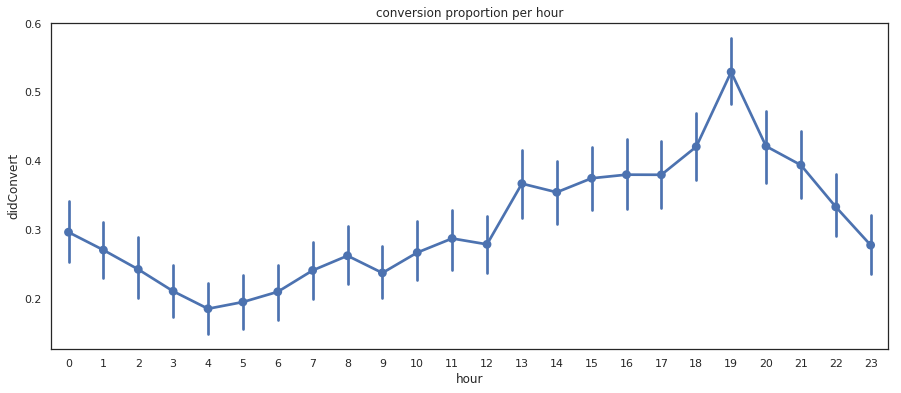

In [230]:
plt.figure(figsize=(15,6))
sns.pointplot(x='hour', y='didConvert', data=DF)
plt.title('conversion proportion per hour')
plt.show()

### Chi-2 tests : independance test between categorical features
To mesure dependency between 2 categorical features, we usually proceed to a chi-2 test done on the contengency table. To do so, I will use the cat_dependance function calling chi2_contengency module from Scipy and returning the Chi-2 value, the p-value, the degree of freedom.  
H0 : features are independant. We reject the null hypothesis with an alpha risk of 5% si p-value < 0.05.

In [231]:
def cat_dependance(df, feat1, feat2, showimg=True):
    contingence = pd.crosstab(columns=df[feat2], index=df[feat1], normalize=False, margins=True, dropna=True)
    chi2, p, dof, expected = chi2_contingency(contingence)
    expected = pd.DataFrame(expected, columns=contingence.columns, index=contingence.index)
    ecarts_pond = ((contingence-expected)/expected).iloc[:-1,:-1]
    if showimg : 
        print('Table de contingence : ')
        print('-'*40)
        print(contingence)
        print('-'*40)
        ax = plt.axes()
        sns.heatmap(ecarts_pond, annot=True, center=0)
        ax.set_title('Ecarts pondérés')
        print(f'p-value test chi2 : {p}')
        if p < 0.05:
            print('p < 0.05, on rejette l\'hypothèse d\'indépendance des variables\n')
        else : 
            print('p > 0.05, les variables sont indépendantes\n')

    return chi2, p, dof, expected, contingence, ecarts_pond

In [232]:
tmp = DF.dropna()
tab_dep = pd.DataFrame(columns=DF.columns, index=DF.columns)

In [233]:
# Independance test for the categorical feature by features: (Test d'indépendance des variables 2 à 2)
categories = ['uuid', 'cr', 'c', 'os', 'sid', 'app', 'ANIMAL', 'CAR_OWNER', 'GARDEN', 'OFFICE_WORKER', 'PARENT', 'hour']
for j in range(len(categories)):
    for i in range(j+1,len(categories)):
        chi2, pval, dof, expected, cont, ecarts_pond = cat_dependance(DF, categories[j], categories[i], showimg=False)
        tab_dep.loc[categories[j], categories[i]]=f'{pval:.2f}'
        tab_dep.loc[categories[i], categories[j]]=f'{pval:.2f}'
        if pval < 0.05:
            print(f'{categories[j]} vs {categories[i]}: p < 0.05, on rejette l\'hypothèse d\'indépendance des variables')
        else : 
            print(f'{categories[j]} vs {categories[i]}: p > 0.05, les variables sont indépendantes')

uuid vs cr: p > 0.05, les variables sont indépendantes
uuid vs c: p > 0.05, les variables sont indépendantes
uuid vs os: p > 0.05, les variables sont indépendantes
uuid vs sid: p > 0.05, les variables sont indépendantes
uuid vs app: p > 0.05, les variables sont indépendantes
uuid vs ANIMAL: p < 0.05, on rejette l'hypothèse d'indépendance des variables
uuid vs CAR_OWNER: p < 0.05, on rejette l'hypothèse d'indépendance des variables
uuid vs GARDEN: p < 0.05, on rejette l'hypothèse d'indépendance des variables
uuid vs OFFICE_WORKER: p < 0.05, on rejette l'hypothèse d'indépendance des variables
uuid vs PARENT: p < 0.05, on rejette l'hypothèse d'indépendance des variables
uuid vs hour: p > 0.05, les variables sont indépendantes
cr vs c: p > 0.05, les variables sont indépendantes
cr vs os: p > 0.05, les variables sont indépendantes
cr vs sid: p > 0.05, les variables sont indépendantes
cr vs app: p > 0.05, les variables sont indépendantes
cr vs ANIMAL: p > 0.05, les variables sont indépendant

### Feature importance
Before going any further in the creation of models, checking features importance with a random forest can give us a good intuition of the most relevant features in our model based on an empirical method.

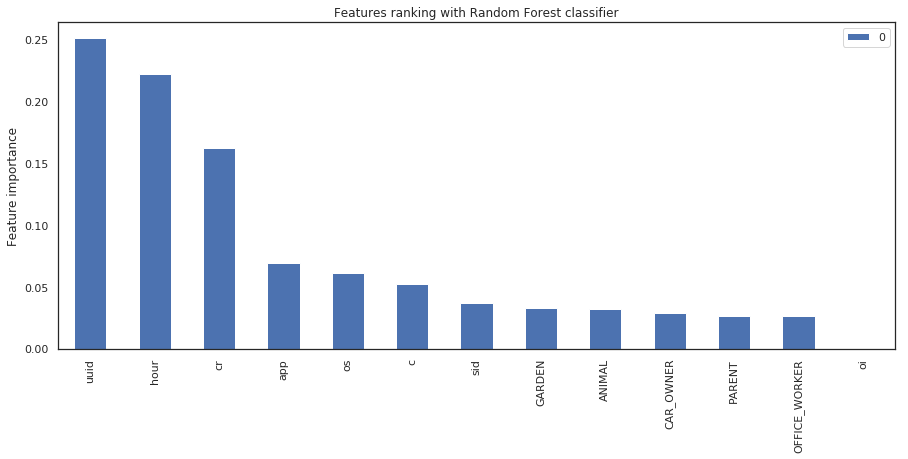

In [234]:
# Fitting a Random Forest
DF_bis = DF.copy()
y = DF_bis.didConvert
del DF_bis['didConvert']
X = DF_bis
del DF_bis

rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=42)
rf_clf.fit(X,y)

# Features importance
pd.DataFrame(rf_clf.feature_importances_,index=X.columns).sort_values(by=0,ascending=False).plot(kind='bar',figsize=(15,6))
plt.ylabel('Feature importance')
plt.title('Features ranking with Random Forest classifier')
plt.show()

del X, y, rf_clf

### One-hot-encoding of the categorical features

In [235]:
# number of distinct values comprised in each categorical features
print('# of distinct values in uuid: ', len(DF.uuid.unique()),
      '\n# of distinct values in oi: ', len(DF.oi.unique()),
      '\n# of distinct values in cr:', len(DF.cr.unique()),
      '\n# of distinct values in c:', len(DF.c.unique()),
      '\n# of distinct values in os:', len(DF.os.unique()),
      '\n# of distinct values in hour:', len(DF.hour.unique()),
      '\n# of distinct values in sid:', len(DF.sid.unique()), 
      '\n# of distinct values in app:', len(DF.app.unique()))

# There is only one id for the client for whom the advertising campaign was run, therefore we delete the oi column
del DF['oi']

DF.head()

# of distinct values in uuid:  500 
# of distinct values in oi:  1 
# of distinct values in cr: 10 
# of distinct values in c: 3 
# of distinct values in os: 2 
# of distinct values in hour: 24 
# of distinct values in sid: 2 
# of distinct values in app: 3


,uuid,cr,c,os,sid,app,ANIMAL,CAR_OWNER,GARDEN,OFFICE_WORKER,PARENT,didConvert,hour
0,316,4.0,2,4,16,7,1,0,0,1,1,0,1
1,316,10.0,3,4,26,9,1,0,0,1,1,0,1
2,316,9.0,2,5,16,7,1,0,0,1,1,1,3
3,316,9.0,1,5,16,7,1,0,0,1,1,1,11
4,316,9.0,1,4,26,22,1,0,0,1,1,0,2


One-hot-encoding of the following features: 
- uuid
- cr
- c 
- os
- hour
- sid
- app

After the encoding of categorial features, the new shape of the dataframe becomes : __(9471, 550)__

In [236]:
DF = pd.get_dummies(DF, columns=['uuid', 'cr', 'c', 'os', 'hour', 'sid', 'app'])

In [237]:
DF.head()

,ANIMAL,CAR_OWNER,GARDEN,OFFICE_WORKER,PARENT,didConvert,uuid_0,uuid_1,uuid_2,uuid_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,sid_16,sid_26,app_7,app_9,app_22
0,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [238]:
DF_bis = DF.copy()
y = DF_bis.didConvert
del DF_bis['didConvert']
X = DF_bis

### Feature importance after applying the one-hot-encoding

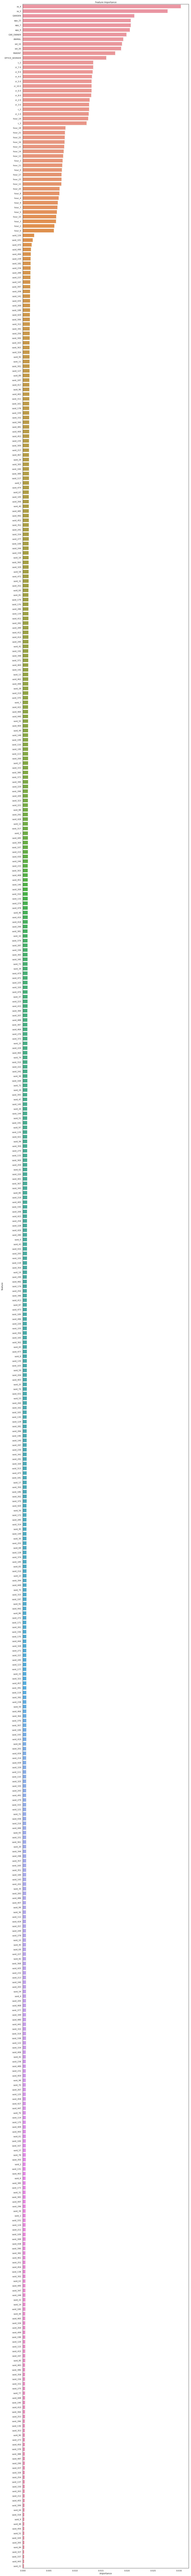

In [239]:
# Calculate Features Importances 
rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=42)
rf_clf.fit(X,y)
columns_selected = DF_bis.columns.values

dict_feature_importance = {'feature': columns_selected, 'importance': rf_clf.feature_importances_}
feature_importances = pd.DataFrame(data=dict_feature_importance).sort_values('importance', ascending=False)

plt.figure(figsize=(15,200))
sns.barplot(x="importance",
            y="feature",
            orient='h',
            data=feature_importances.sort_values(by="importance",
                                                 ascending=False))
plt.title('Feature Importance')
plt.tight_layout()

We could remove the uuid feature, since a unique uuid for a specific row doesn't seem to be too relevant. Besides, in the case we would want to predict the conversion of new user, we need to remove this feature first. But for now, I decide to maintain this feature

## 2.3 Train test split
In order to test our model, we first split the dataset in 2 sets : train 70% and test 30% of observations.  
Since, our conversion distribution is unbalanced, I want to maintain the same positive rate of conversion in each split, for this I will be using the stratify method in the train_test_split function.

In [240]:
DF_bis2 = DF.copy()
y = DF_bis2.didConvert
del DF_bis2['didConvert']
X = DF_bis2

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

## 2.4 Models selection
To select the most efficient model to predict the test set, I am testing several models and will conduct an analysis on the obtained scores. I am mostly refering to the AUC of the precision-recall curve and F1 score metrics to evaluate my models, but I have also printed the accuracy score to get a larger view. Below, I will be testing 11 different classifiers without optimization of their hyperparameters for now, and later I will build an ensemble classifier from the best classifiers among the 11 tested and will perform a voting system on the ensemble classifier and compare it to the individual models.

### Precision-Recall AUC score with cross validation

In [242]:
def prauc_score(y_test, y_pred, weight='balanced'):
    """
    Cette fonction renvoie le score d'aire sous la courbe Precision-Recall
    """
    sw = compute_sample_weight(class_weight=weight, y=y_test)
    precision, recall, _ = precision_recall_curve(sample_weight=sw, y_true=y_test, 
                                                  probas_pred=y_pred, pos_label=1)
    area = auc(x=recall, y=precision)
    return area

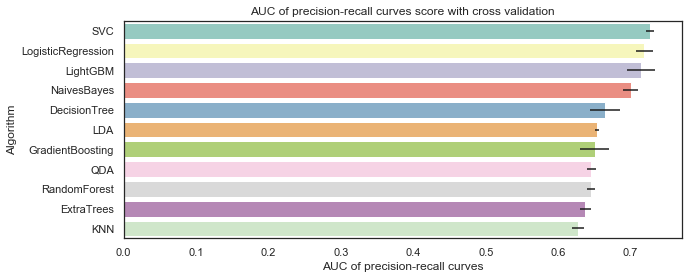

In [33]:
random_state = 42
kfold = StratifiedKFold(n_splits=3)
score = make_scorer(prauc_score, needs_proba=False)
w1 = 'balanced' # to balance the weights of the class

classifiers = []
classifiers.append(SVC(random_state=random_state, probability=True, class_weight=w1))
classifiers.append(DecisionTreeClassifier(random_state=random_state, class_weight=w1))
classifiers.append(RandomForestClassifier(random_state=random_state, class_weight=w1, n_jobs=-1))
classifiers.append(ExtraTreesClassifier(random_state=random_state, class_weight=w1, n_jobs=-1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier(n_jobs=-1))
classifiers.append(QuadraticDiscriminantAnalysis())
classifiers.append(GaussianNB())
classifiers.append(LogisticRegression(random_state = random_state, class_weight=w1, n_jobs=-1))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier(random_state=random_state, is_unbalance=True , application='binary', objective='binary', n_jobs=-1))

cv_results = []
cv_pred = []
for clf in classifiers :
    cv_results.append(cross_val_score(estimator=clf, X=X_train.values, y=y_train.values,
                                      scoring=score, cv=kfold, n_jobs=-1))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm": ["SVC","DecisionTree", "RandomForest","ExtraTrees",
                       "GradientBoosting","KNN","QDA","NaivesBayes", "LogisticRegression","LDA", "LightGBM"]})

# Plot ranking modèles :
plt.figure(figsize=(10,4))
g = sns.barplot("CrossValMeans","Algorithm", data=cv_res.sort_values(by='CrossValMeans', ascending=False),
                palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("AUC of precision-recall curves")
g = g.set_title("AUC of precision-recall curves score with cross validation")
plt.show()

### <font color='green'>CE QUE J'AURAIS PU RAJOUTER POUR VERIFIER L'OVERFITTING : VOIR LA VARIANCE</font>

In [ ]:
# Plot ranking modèles selon leurs variance  :
'''
plt.figure(figsize=(10,4))
g = sns.barplot("CrossValerrors","Algorithm", data=cv_res.sort_values(by='CrossValerrors', ascending=True),
                palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("AUC of precision-recall curves")
g = g.set_title("AUC of precision-recall curves score with cross validation")
plt.show()
'''

### F1 score with cross-validation

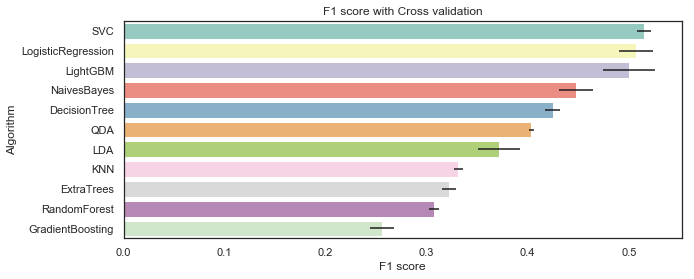

In [34]:
random_state = 42
kfold = StratifiedKFold(n_splits=3)
score = make_scorer(f1_score, needs_proba=False)
w1 = 'balanced' # to balance the weights of the class

classifiers = []
classifiers.append(SVC(random_state=random_state, probability=True, class_weight=w1))
classifiers.append(DecisionTreeClassifier(random_state=random_state, class_weight=w1))
classifiers.append(RandomForestClassifier(random_state=random_state, class_weight=w1, n_jobs=-1))
classifiers.append(ExtraTreesClassifier(random_state=random_state, class_weight=w1, n_jobs=-1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier(n_jobs=-1))
classifiers.append(QuadraticDiscriminantAnalysis())
classifiers.append(GaussianNB())
classifiers.append(LogisticRegression(random_state = random_state, class_weight=w1, n_jobs=-1))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier(random_state=random_state, is_unbalance=True , application='binary', objective='binary', n_jobs=-1))

cv_results = []
cv_pred = []
for clf in classifiers :
    cv_results.append(cross_val_score(estimator=clf, X=X_train.values, y=y_train.values,
                                      scoring=score, cv=kfold, n_jobs=-1))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm": ["SVC","DecisionTree", "RandomForest","ExtraTrees",
                       "GradientBoosting","KNN","QDA","NaivesBayes", "LogisticRegression","LDA", "LightGBM"]})

# Plot ranking modèles :
plt.figure(figsize=(10,4))
g = sns.barplot("CrossValMeans","Algorithm", data=cv_res.sort_values(by='CrossValMeans', ascending=False),
                palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("F1 score")
g = g.set_title("F1 score with Cross validation")
plt.show()

### Accuracy score with cross validation

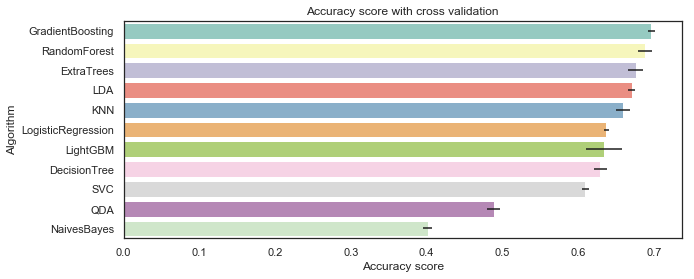

In [35]:
random_state = 42
kfold = StratifiedKFold(n_splits=3)
score = make_scorer(accuracy_score, needs_proba=False)
w1 = 'balanced' # to balance the weights of the class

classifiers = []
classifiers.append(SVC(random_state=random_state, probability=True, class_weight=w1))
classifiers.append(DecisionTreeClassifier(random_state=random_state, class_weight=w1))
classifiers.append(RandomForestClassifier(random_state=random_state, class_weight=w1, n_jobs=-1))
classifiers.append(ExtraTreesClassifier(random_state=random_state, class_weight=w1, n_jobs=-1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier(n_jobs=-1))
classifiers.append(QuadraticDiscriminantAnalysis())
classifiers.append(GaussianNB())
classifiers.append(LogisticRegression(random_state = random_state, class_weight=w1, n_jobs=-1))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier(random_state=random_state, is_unbalance=True , application='binary', objective='binary', n_jobs=-1))

cv_results = []
cv_pred = []
for clf in classifiers :
    cv_results.append(cross_val_score(estimator=clf, X=X_train.values, y=y_train.values,
                                      scoring=score, cv=kfold, n_jobs=-1))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm": ["SVC","DecisionTree", "RandomForest","ExtraTrees",
                       "GradientBoosting","KNN","QDA","NaivesBayes", "LogisticRegression","LDA", "LightGBM"]})

# Plot ranking modèles :
plt.figure(figsize=(10,4))
g = sns.barplot("CrossValMeans","Algorithm", data=cv_res.sort_values(by='CrossValMeans', ascending=False),
                palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Accuracy score")
g = g.set_title("Accuracy score with cross validation")
plt.show()

## 2.5 Optimisation of the best models
Models we are retaining are those with the higher AUC of Precision-Recall curve / F1-score:   
♦ SVC  
♦ Logistic regression  
♦ LightGBM  
In order to increase the efficiency of the retained models, we will be optimizing their hyperparameters and we will be keeping the best of them. To reach this purpose, we will be conducting a GridSearch with a cross-validation (K-fold with K = 3).

In [ ]:
# This cross validation part was the longest to train, de-comment to rerun it
'''
score = make_scorer(prauc_score, needs_proba=False)
param = []
# SVC Parameters 
param.append({'kernel': ['rbf', 'linear', 'poly'], 'gamma': [0.1, 1, 10, 100], 'C': [0.1, 1, 10, 100]})
# Logistic Regression parameters
param.append({'penalty' : ['l1', 'l2'], 'tol': [1e-4, 1e-8, 1e-2], 'C': [0.1, 1, 10, 100], 
              'class_weight' : ['balanced', None], 'max_iter' : [50, 100, 200]})

classifiers = []
classifiers.append(SVC(random_state=random_state, probability=True))
classifiers.append(LogisticRegression(random_state = random_state, n_jobs=-1))

clf_name = ['SVC','Logit']
for i, clf in enumerate(classifiers):
    clf = GridSearchCV(clf, param[i], cv=kfold, return_train_score=False, scoring=score, refit=True, n_jobs=-1)
    clf.fit(X_train.values, y_train.values.ravel())
    filename = f'{clf_name[i]}_best.sav'
    joblib.dump(clf.best_estimator_, filename)
'''

I am not performing a cross validation on the lightGBM since it is too much time-consuming on my laptop, instead I will try different hyperparameters

In [244]:
# With default parameters
lgb1 = LGBMClassifier(learning_rate = 0.1,
                      boosting_type = 'gbdt',
                      application = 'binary',
                      objective = 'binary',
                      n_jobs = -1, 
                      max_depth = -1, 
                      num_leaves=31,
                      verbose = 1, 
                      is_unbalance=True)

lgb1.fit(X_train, y_train.values.ravel())
y_pred = lgb1.predict(X_test)
prauc_score(y_test, y_pred=y_pred)

0.7150563214028489

In [245]:
# With a lower learning rate
lgb2 = LGBMClassifier(learning_rate = 0.03, 
                      boosting_type = 'gbdt',
                      application = 'binary',
                      objective = 'binary',
                      n_jobs = -1, 
                      max_depth = -1, 
                      num_leaves=31,
                      verbose = 1, 
                      is_unbalance=True)

lgb2.fit(X_train, y_train.values.ravel())
y_pred = lgb2.predict(X_test)
prauc_score(y_test, y_pred=y_pred)

0.7270953865692664

In [246]:
# With a lower number of leaves since it is a small dataset
# With a lower learning rate and more iterations
lgb3 = LGBMClassifier(learning_rate = 0.01,
                      num_iterations=500,
                      boosting_type = 'gbdt',
                      application = 'binary',
                      objective = 'binary',
                      n_jobs = -1, 
                      max_depth = -1,
                      num_leaves=10,
                      verbose = 1, 
                      is_unbalance=True)

lgb3.fit(X_train, y_train.values.ravel())
y_pred = lgb3.predict(X_test)
prauc_score(y_test, y_pred=y_pred)

0.7400471312255295

In [205]:
# Chargement des modèles optimisés:
SVC_best = joblib.load('SVC_best.sav')
Logit_best = joblib.load('Logit_best.sav')
LightGBM_best = lgb3
model_list = [SVC_best, Logit_best , LightGBM_best]
clf_name = ['SVC', 'Logit', 'LightGBM']

## 2.6  Predictions with the best models
We can visualize on the precision-recall curve and the results from the above models, as well as their confusion matrix.  
All 3 models reach a score with an AUC reaching around 68%

In [206]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Cette fonction plot la matrice de confusion. Elle peut 
    etre normalisée ou non avec le parametre 'normalize = True'
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=f'{title} Matrice de confusion',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [207]:
def plot_prauc(model_list, y_test, X_test, pos_label=1, clf_name=None, weight='balanced', figsize=(8,6)):
    """
    Cette fonction plot la courbe de Precision-Recall 
    (Recall en abscisse et Precision en ordonnee)
    Ainsi que l'aire sous la courbe.
    """
    plt.figure(figsize=figsize)
    for i, model in enumerate(model_list):
        sw = compute_sample_weight(class_weight=weight, y=y_test)
        y_pred_pb = model.predict_proba(X_test)
        precision, recall, _ = precision_recall_curve(sample_weight=sw,
                                                      y_true=y_test, probas_pred=y_pred_pb[:, 1], 
                                                      pos_label=pos_label)
        area = auc(x=recall, y=precision)
        model_name = clf_name[i]
        print(f'{model_name} : AUC = {area:.3f}')
        plt.plot(recall, precision, marker=',', label=model_name, )
        plt.title('Courbe de Precision-Recall')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim(0.5,1.01)
        plt.legend()
    plt.plot([0, 1], [1,min(precision)], linestyle='--')
    plt.draw()
    return 

### AUC Precision-Recall Scores for each models

SVC : AUC = 0.667
Logit : AUC = 0.687
LightGBM : AUC = 0.682


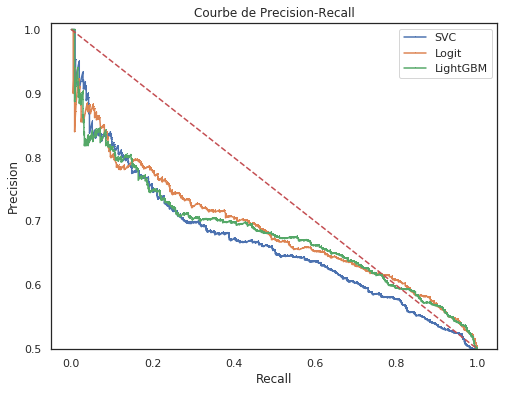

In [208]:
plot_prauc(model_list=model_list, X_test=X_test, y_test=y_test, clf_name=clf_name)

### Confusion matrices

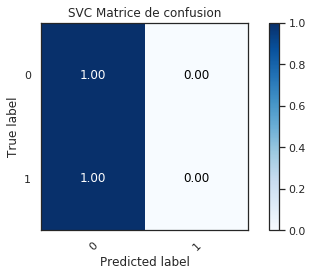

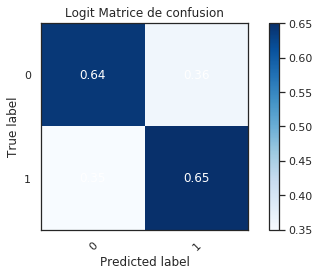

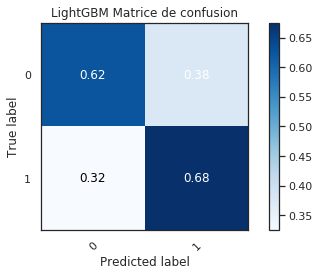

In [209]:
# Confusion matrix
for i, model in enumerate(model_list):
    y_pred = model.predict(X_test.values)
    plot_confusion_matrix(y_pred=y_pred, y_true=y_test.values, classes=[0,1], normalize=True, title=f'{clf_name[i]}')

The logistic regression and the lightGBM seems to be the best models here.
While the three models share approximately the same AUC for the precision recall curve, the SVC only detects only negative conversion and troubles to figure out which logs will be a positive conversion. 
LightGBM is the best model here if our main concern is to detect which logs will led to a positive in-store conversion. According to the confusion matrix, the lightGBM will predict 68% of the positive conversions and 62% of the negative conversions.

## 2.7 Ensembling
Ensembling consists in retrieving predictions from different classifiers and to assemble them. Here we are doing so by using the average of previous predictions. Here all four models have the same AUC, but in the case that a classifier would have performed much better, we could have give more importance to the better model. I have tried to an ensembling model, yet It didn't perform better than the individual models. I believe with another algorithm than SVC, it might have performed a little better.

In [268]:
# Ensembling des classifieurs:
clf1 = SVC_best
clf2 = Logit_best
clf3 = LightGBM_best

ensemble_clf = VotingClassifier(estimators=[('SVC',clf1),('Logit',clf2),('lightGBM',clf3)],
                                        voting='soft', weights=[1,1,1])
ensemble_clf.fit(X_train.values, y_train.values)

VotingClassifier(estimators=[('SVC', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)), ('Logit', LogisticRegression(C=0.1, class_weight='balanced'...silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=1))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 1, 1])

SVC : AUC = 0.685


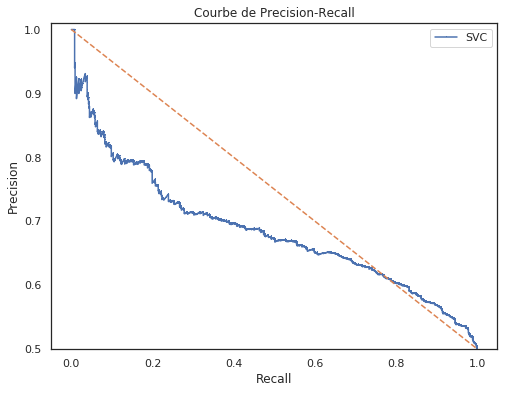

In [269]:
model_list = [ensemble_clf]
plot_prauc(model_list=model_list, X_test=X_test, y_test=y_test, clf_name=clf_name)

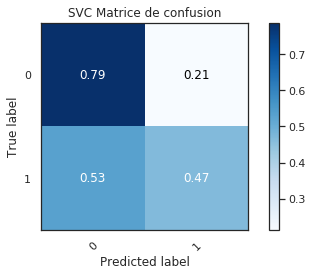

In [270]:
# Confusion matrix
for i, model in enumerate(model_list):
    y_pred = model.predict(X_test.values)
    plot_confusion_matrix(y_pred=y_pred, y_true=y_test.values, classes=[0,1], normalize=True, title=f'{clf_name[i]}')

# <font color='blue'> 3. Review: Reflect on your work for the above and how you would improve it given more time. 
<font color='blue'> The aim of this task is to identify your ability to think creatively and reflectively about problems. Some specific questions to consider include:  
♦ Do you think your class is extensible to other problems using the same data?  
♦ How would you test the functionality you have developed for your class?  
♦ Do you think your developed model could be put into production? Why?  
♦ Why have you chosen the performance metric(s) that you have reported?  
♦ What external data-sets do you think would enrich the performance of your model?</font>  

The purpose of my class was mainly to represent the data in each of my files, so that I could generate the necessary features of the dataframe I would work on.  

The best way in my view to test the functionalities of the class would be to do a unit test, to ensure that if I decide to add future functionalities later, they would work properly.  

Regarding the production, I don't think it would be put in production, the code I wrote above was mostly to illustrate the analysis, besides It would also depends on what we want to focus on, that is to say whether a log led to a positive/negative in-store conversion. With more time spent on this usecase, I would have tested more feature engineering, other hyperparameters, other classifiers or a MLP and maybe try ensembling with other algorithms or even Stacking.  

I have decided to focus on the AUC of the precision-recall curve and F1-score because they take into account the imbalance of the dataset and are less biased than accuracy score in this case. If the dataset would have been 
balanced, then I would have use a ROC curve and the accuracy score as metrics.  

Regarding the external datasets, I believe data such as geolocation data that would better qualify the user could have been interesting, but also the weather with a hour/day granularity (scrapped on a weather website) as it can be a key factor. In a similar project I conducted last year, I added many external datasets from opendatasoft and Insee's website, including data such as everything concerning tertiary sector, restaurants, schools, etc,  that were around the local.